## Post-process CZM simulation result

In [115]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.image as mpimg
import seaborn as sns
import math

from scipy.stats import binned_statistic

import warnings
warnings.filterwarnings('ignore')


In [2]:
# read elemental nodal information
cz_ele_info = pd.read_csv('czm_post/cz_ele_info.txt', header=None) 
cz_index = cz_ele_info[0].to_numpy()
cz_ele_info = cz_ele_info.set_index([0])

bulk_ele_info = pd.read_csv('czm_post/bulk_ele_info.txt', header=None) 
bulk_index = bulk_ele_info[0].to_numpy()
bulk_ele_info = bulk_ele_info.set_index([0])

node_info = pd.read_csv('czm_post/node_info.txt', header=None)

# read field output
cz_stress = pd.read_fwf('czm_post/czm_MaxPrincipalStress.rpt', sep=' ', skiprows=7, header=None)
node_displacement = pd.read_csv('czm_post/cz_coat_860D_bend90_20stiff.csv')

# Clean displacement data (log format to datasheet format)

# # index
num_cz = cz_ele_info.shape[0]
num_bulk = bulk_ele_info.shape[0]
num_node = node_info.shape[0]
num_step = cz_stress.shape[0]


### Extract nodal displacement information
#### (Uncomment it if dealing with new data. Re-run takes 20min)

In [101]:
# prepare for nodal loop
temp_df = node_displacement.loc[node_displacement['    Node Label'] == 1]
num_frame = temp_df.shape[1]
num_frame = 1001
used_node = node_displacement['    Node Label'].unique()

# claim space to store u1, u2, x, and y info
nu1 = pd.DataFrame()
nu2 = pd.DataFrame()
nx = pd.DataFrame()
ny = pd.DataFrame()

# select data
for i in range(0, len(used_node)):
    select_df = node_displacement.loc[node_displacement['    Node Label'] == used_node[i]]
    select_df.reset_index(inplace=True)  
    
    node_name = used_node[i]
    
    nu1[node_name] = select_df['          U-U1']
    nu2[node_name] = select_df['          U-U2']
    nx[node_name] = select_df['X']
    ny[node_name] = select_df['Y']

nu1.to_csv('czm_post/860D_bend90_20stiff_nu1_output.csv', float_format='%.4f', index=False)
nu2.to_csv('czm_post/860D_bend90_20stiff_nu2_output.csv', float_format='%.4f', index=False)
nx.to_csv('czm_post/860D_bend90_20stiff_nx_output.csv', float_format='%.4f', index=False)
ny.to_csv('czm_post/860D_bend90_20stiff_ny_output.csv', float_format='%.4f', index=False)

;

nu1 = pd.read_csv('czm_post/860D_20stiff_bend90_nu1_output.csv')
nu2 = pd.read_csv('czm_post/860D_20stiff_bend90_nu2_output.csv')
nx = pd.read_csv('czm_post/860D_20stiff_bend90_nx_output.csv')
ny = pd.read_csv('czm_post/860D_20stiff_bend90_ny_output.csv')

In [102]:
# Calculate the x coordinates (center) of each cz_ele
# thickness of each cz_ele (measure opening)

cz_center = np.empty([num_cz, 2])
cz_delta = np.empty([num_cz, 1001])
cz_delta_final = np.empty([num_cz])
cz_delta_beginning = np.empty([num_cz])

for i in range(0, num_cz):
    cz_i = cz_index[i]
    # for each cz, average the x coord of its four nodes
    ct_x_b = 0
    ct_y_b = 0
    ct_x_t = 0
    ct_y_t = 0

    ct_x_b = nx[str(cz_ele_info[1][cz_i])].iloc[-1] + nx[str(cz_ele_info[2][cz_i])].iloc[-1]
    ct_y_b = ny[str(cz_ele_info[1][cz_i])].iloc[-1] + ny[str(cz_ele_info[2][cz_i])].iloc[-1]
    
    ct_x_t = nx[str(cz_ele_info[3][cz_i])].iloc[-1] + nx[str(cz_ele_info[4][cz_i])].iloc[-1]
    ct_y_t = ny[str(cz_ele_info[3][cz_i])].iloc[-1] + ny[str(cz_ele_info[4][cz_i])].iloc[-1]
    
    cz_delta_final[i] = math.dist([ct_x_b, ct_y_b], [ct_x_t, ct_y_t])

    cz_center[i, 0] = (ct_x_b + ct_x_t) / 4
    cz_center[i, 1] = (ct_y_b + ct_y_t) / 4


    

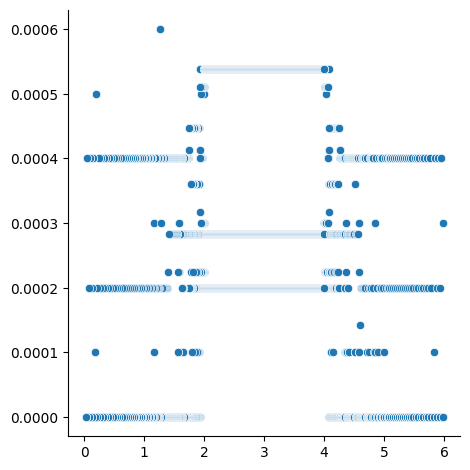

In [9]:
# Plot miles per gallon against horsepower with other semantics
sns.relplot(x=cz_center[:, 0], y=cz_delta_final)
plt.

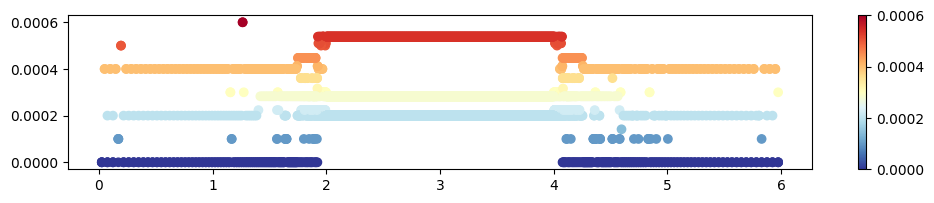

In [59]:
cm = plt.cm.get_cmap('RdYlBu_r')
sc = plt.scatter(cz_center[:, 0], cz_delta_final, c=cz_delta_final,  cmap=cm)
plt.colorbar(sc)
plt.show()

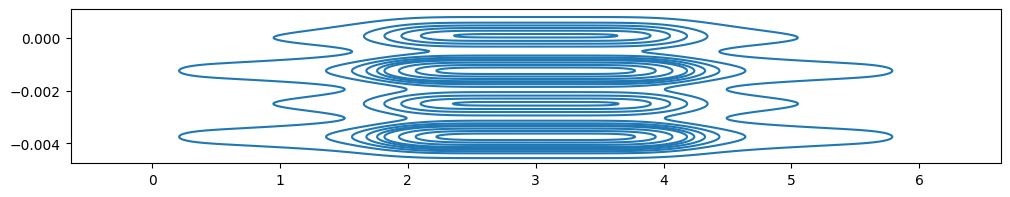

In [76]:
# Basic 2D density plot
sns.kdeplot(x=cz_center[:, 0], y=cz_center[:, 1])
plt.show()

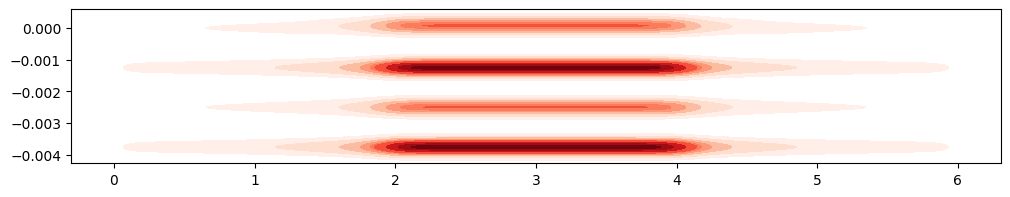

In [80]:
# Basic 2D density plot
sns.kdeplot(x=cz_center[:, 0], y=cz_center[:, 1], cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

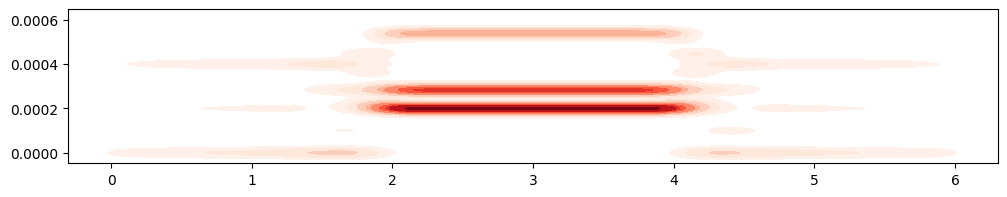

In [79]:
# Basic 2D density plot
sns.kdeplot(x=cz_center[:, 0], y=cz_delta_final, cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

(0.0, 3486.0, 14.0, 0.0)

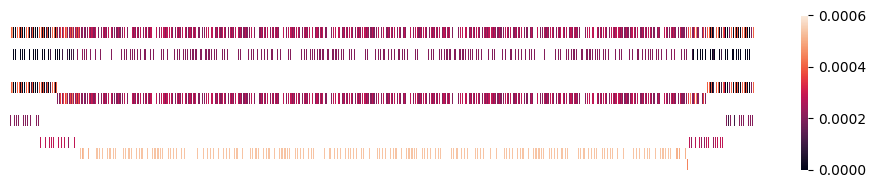

In [112]:
df_temp = pd.DataFrame(dict(x=cz_center[:, 0], y=cz_center[:, 1], intensity=cz_delta_final))
cz_open_map = df_temp.pivot(index = 'y', columns='x', values='intensity')
sns.heatmap(cz_open_map, annot=False)
plt.axis('off')
# plt.show()

In [114]:
cz_temp = df_temp
cz_temp.sort_values(by=['x'])

,x,y,intensity
1249,0.025150,-0.00125,0.0000
5497,0.025150,0.00000,0.0000
1248,0.025150,-0.00375,0.0000
1247,0.025150,-0.00250,0.0000
1244,0.050300,-0.00375,0.0004
...,...,...,...
619,5.949700,-0.00125,0.0004
5372,5.974775,0.00000,0.0003
624,5.974850,-0.00375,0.0000
623,5.974850,-0.00125,0.0000


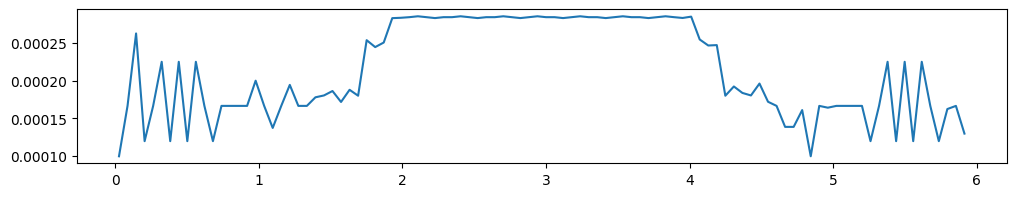

In [133]:
# Compute average crack opening
mean_stat = binned_statistic(cz_center[:, 0], cz_delta_final, statistic='mean', bins=100)
plt.plot( mean_stat.bin_edges[0:-1], mean_stat.statistic)
# for i in range(0, 6, 0.05):
#     cz_cell = cz_temp.loc[cz_temp['x'] >= i & cz_temp['x'] < i+0.05]




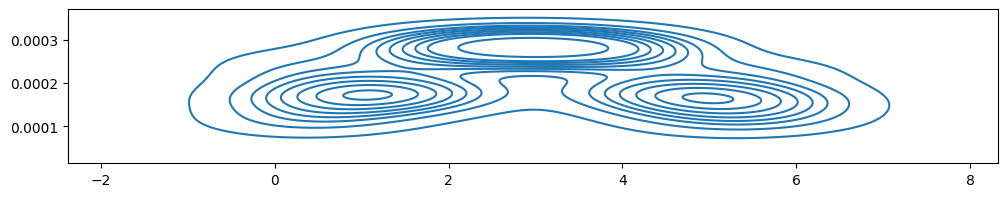

In [136]:
sns.kdeplot(x=mean_stat.bin_edges[0:-1], y=mean_stat.statistic)
plt.show()

In [131]:
mean_stat.bin_edges

array([0.02515 , 0.084647, 0.144144, 0.203641, 0.263138, 0.322635,
       0.382132, 0.441629, 0.501126, 0.560623, 0.62012 , 0.679617,
       0.739114, 0.798611, 0.858108, 0.917605, 0.977102, 1.036599,
       1.096096, 1.155593, 1.21509 , 1.274587, 1.334084, 1.393581,
       1.453078, 1.512575, 1.572072, 1.631569, 1.691066, 1.750563,
       1.81006 , 1.869557, 1.929054, 1.988551, 2.048048, 2.107545,
       2.167042, 2.226539, 2.286036, 2.345533, 2.40503 , 2.464527,
       2.524024, 2.583521, 2.643018, 2.702515, 2.762012, 2.821509,
       2.881006, 2.940503, 3.      , 3.059497, 3.118994, 3.178491,
       3.237988, 3.297485, 3.356982, 3.416479, 3.475976, 3.535473,
       3.59497 , 3.654467, 3.713964, 3.773461, 3.832958, 3.892455,
       3.951952, 4.011449, 4.070946, 4.130443, 4.18994 , 4.249437,
       4.308934, 4.368431, 4.427928, 4.487425, 4.546922, 4.606419,
       4.665916, 4.725413, 4.78491 , 4.844407, 4.903904, 4.963401,
       5.022898, 5.082395, 5.141892, 5.201389, 5.260886, 5.320

In [ ]:
# df_temp = node_displacement.groupby("    Node Label")

In [ ]:
# df_temp.reset_index()

In [ ]:
# node_displacement.groupby("    Node Label", group_keys=True)

In [ ]:
# print(df_temp)

In [60]:
bulk_ele_info

,1,2,3
0,,,
1,24174,24175,24176
2,24177,24178,24179
3,24180,24181,24182
4,24183,24184,24185
5,24186,24187,24188
...,...,...,...
46196,2037,2038,22069
46197,22070,22071,2036
46198,2036,2037,22070
